# IL2233 Lab 2 - ARIMA Model and Prediction

## Imports

In [19]:
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import numpy as np
from random import gauss, seed, randint
from pandas import Series, plotting, read_excel, DataFrame
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, acovf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from numpy.fft import fft, rfft
from scipy.io import loadmat
from scipy.signal import spectrogram
from math import sqrt

**Helper functions**

In [44]:
# Line plot, histogram, density plot, box plot, lag-1 plot, ACF and PACF graphs
def plot_all(series: Series, lags: int):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
    fig.subplots_adjust()

    series.plot(ax=axes[0,0], kind='line', title='Line plot', xlabel='SV #', ylabel='Value')
    series.plot(ax=axes[0,1], kind='hist', title='Histogram', xlabel='Value', ylabel='frequency')
    series.plot(ax=axes[1,0], kind='box', title='Box plot')
    series.plot(ax=axes[1,1], kind='density', title='Density plot', xlabel='', ylabel='density')
    plotting.lag_plot(series, ax=axes[2,0], lag=1)
    plotting.lag_plot(series, ax=axes[2,1], lag=2)
    autocorrelation_plot(series, ax=axes[3,0])
    plot_pacf(series, lags=lags, ax=axes[3,1]);

# # Histogram, density plot, box plot
# def plot_hist_dens_box(series: Series):
#     fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
#     fig.subplots_adjust()

#     series.plot(ax=axes[0,0], kind='hist', title='Histogram', xlabel='Value', ylabel='frequency')
#     series.plot(ax=axes[0,1], kind='box', title='Box plot')
#     series.plot(ax=axes[1,0], kind='density', title='Density plot', xlabel='', ylabel='density')
#     plotting.lag_plot(series, ax=axes[2,0])

def ljungbox(series: Series):
    return sm.stats.acorr_ljungbox(series)

def adfuller_test(series: Series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'{key}, {value}')


def gen_arma(lagcoeffs_ar: list[int] = [], lagcoeffs_ma: list[int] = [], nsample: int = 250):
    lagcoeffs_ar = np.r_[1, -np.array(lagcoeffs_ar)] if len(lagcoeffs_ar) > 0 else np.array([1])
    lagcoeffs_ma = np.r_[1, np.array(lagcoeffs_ma)] if len(lagcoeffs_ma) > 0 else np.array([1])

    proc = ArmaProcess(lagcoeffs_ar, lagcoeffs_ma)

    generated_time_series = proc.generate_sample(nsample)
    return generated_time_series, proc

# Task 1: Stationarity of AR models

<Axes: title={'center': '4)'}>

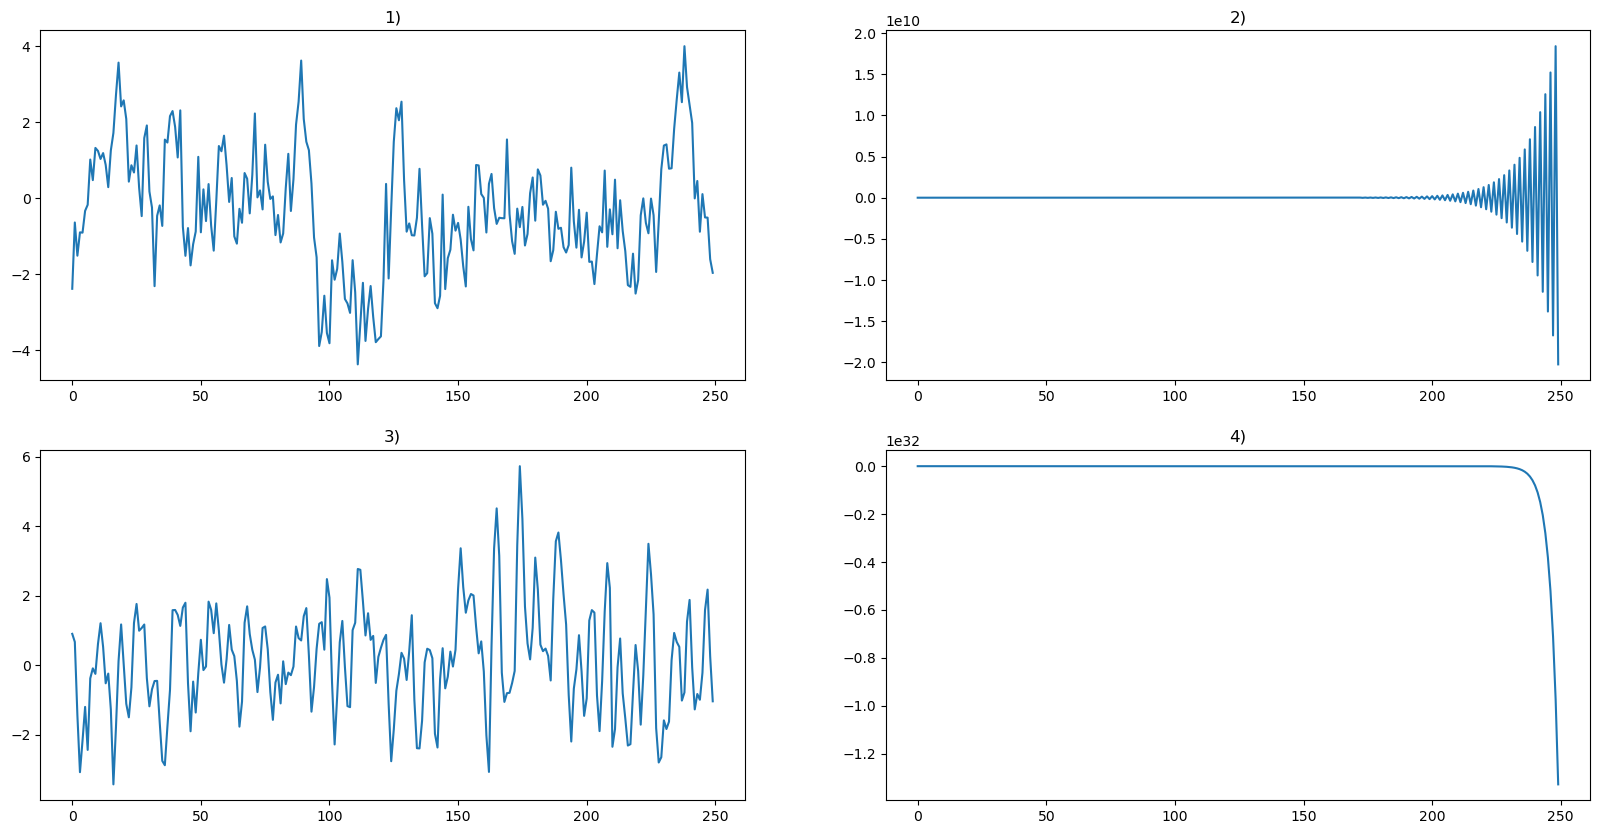

In [21]:
s1, p1 = gen_arma(lagcoeffs_ar=[0.8])
s2, p2 = gen_arma(lagcoeffs_ar=[-1.1])
s3, p3 = gen_arma(lagcoeffs_ar=[1, -0.5])
s4, p4 = gen_arma(lagcoeffs_ar=[1, 0.5])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.subplots_adjust()
Series(s1).plot(ax=axes[0,0], kind='line', title='1)')
Series(s2).plot(ax=axes[0,1], kind='line', title='2)')
Series(s3).plot(ax=axes[1,0], kind='line', title='3)')
Series(s4).plot(ax=axes[1,1], kind='line', title='4)')

**Judging visually:**

None of the time series seem to be weakly stationary. In the case of 2), the mean may be constant but the variance is not.
We find that 3) could be potentially stationary, but further tests are required to determine this.

**Judging by coefficients:**

To determine if the generated time series are stationary we can check the following constraints on the coefficients:
- For p = 1: <u>−1 < $\phi_1$ < 1</u>.
- For p = 2: <u>−1 < $\phi_2$ < 1</u> AND <u>$\phi_2$ + $\phi_1$ < 1</u> AND <u>$\phi_2$ − $\phi_1$ < 1</u>.

- 1) AR(1) = $0.8x_{t-1} + \epsilon_t           \rightarrow -1 < \phi_1 = 0.8 < 1$, which **fulfills** the stationarity condition for $p = 1$
- 2) AR(1) = $-1.1x_{t-1} + \epsilon_t          \rightarrow -1 > \phi_1 = -1.1$, which does **not fulfill** the stationarity condition for $p = 1$
- 3) AR(2) = $1x_{t-1} - 0.5x_{t-2} \epsilon_t  \rightarrow -1 < \phi_2 = -0.5 < 1$, $\phi_2 + \phi_1 = 0.5 < 1$, and $\phi_2 - \phi_1 = 0.5 < 1$, which **fulfills** the stationarity condition for $p = 2$
- 4) AR(2) = $1x_{t-1} + 0.5x_{t-2} \epsilon_t  \rightarrow -1 < \phi_2 = 0.5 < 1$, $\phi_2 + \phi_1 = 1.5 > 1$, and $\phi_2 - \phi_1 = -0.5 < 1$, which does **not fulfill** the stationarity condition as the second criteria is not fulfilled

**Built-in function in statsmodels:**

From the output below, we validate that manual stationarity calculations were correct.

In [22]:
print(f"AR process 1 is stationary: {p1.isstationary}")
print(f"AR process 2 is stationary: {p2.isstationary}")
print(f"AR process 3 is stationary: {p3.isstationary}")
print(f"AR process 4 is stationary: {p4.isstationary}")

AR process 1 is stationary: True
AR process 2 is stationary: False
AR process 3 is stationary: True
AR process 4 is stationary: False


**Augmented Dickey-Fuller Test:**

One final stationarity test is done on the time series applying the ADF test. For each of the test outputs, we check if the ADF-statistic is less than all the critical values and also if the p-value is less than 0.5.

Our findings indicate the same results as previous tests.

In [23]:
adfuller_test(Series(s1))
print("-"*40)
adfuller_test(Series(s2))
print("-"*40)
adfuller_test(Series(s3))
print("-"*40)
adfuller_test(Series(s4))

ADF Statistic: -4.603632435452565
p-value: 0.00012719290960214462
Critial Values:
1%, -3.4569962781990573
Critial Values:
5%, -2.8732659015936024
Critial Values:
10%, -2.573018897632674
----------------------------------------
ADF Statistic: -98673132643.33157
p-value: 0.0
Critial Values:
1%, -3.4568881317725864
Critial Values:
5%, -2.8732185133016057
Critial Values:
10%, -2.5729936189738876
----------------------------------------
ADF Statistic: -7.559300143370657
p-value: 3.0400081703995656e-11
Critial Values:
1%, -3.457105309726321
Critial Values:
5%, -2.873313676101283
Critial Values:
10%, -2.5730443824681606
----------------------------------------
ADF Statistic: 5.546386634209641e+16
p-value: 1.0
Critial Values:
1%, -3.4573260719088132
Critial Values:
5%, -2.873410402808354
Critial Values:
10%, -2.573095980841316


## Task 1 - Questions

- **With visual inspection, how do you identify if a time series is stationary or not?**

By visual inspection one can check what the mean seems to be for various intervals of the time series, but also for the time series as a whole. Variance is also easy to visually inspect over slices in time and for the whole series. Another easy inspection methods includes finding seasonality, i.e. repeating patterns.
'
- **How do you judge the stationarity of time series using the unit-root method? Does it always give correct results?**

We use the ADF test to judge stationarity. Based on the ADF statistic, negative values implies less probability of non stationarity.

- **What is the role of component $\epsilon_t$ in the model? Why is it important?**

$\epsilon_t$ is a Gaussian white noise with normal distribution (0, 1). There is always a measure of error to future values based on prediction from past data points, which need to be taken into consideration. The error $\epsilon_t$ does this.

- **To have an AR(p) model be stationary, is there any requirement on the auto-regressive coefficients? List the constraints for AR(1) and AR(2) models**

The following constraints are put on the coefficients to determine stationarity of the AR(p) model, where $\phi_t$ is the coefficient:

For p = 1: <u>−1 < $\phi_1$ < 1</u>

For p = 2: <u>−1 < $\phi_2$ < 1</u> AND <u>$\phi_2$ + $\phi_1$ < 1</u> AND <u>$\phi_2$ − $\phi_1$ < 1</u>

# Task 2: ACF, PACF of AR models

### Are all of them stationary? **Judging visually:**
At a first glance, 2) and 4) seem to be weakly stationary. 1) show signs of great variation of mean and variance at different intervals, and thus can't be considered weakly stationary. 3) could potentially be weakly stationary, but further tests are required to determine this.

### Are there any outliers? Why?
Looking at the box plot, we can see outliers in most cases. This, of course, depends on the gaussian white noise whether outliers exist or not. Our theory is that when the data points in a time series differ by a certain variance from the mean, this spawns outliers either above or below the box plot (depending on the data point being above or below the mean)

### Do you observe any auto-correlation from the lag plots?
The lag-1 plot seems to give a measure of autocorrelation, at least more than lag-2. Despite this, there is no clear autocorrelation for any of the given models.

### What characteristics can you observe from the ACF graphs of the AR(p) models?
Over time, the ACF graph converges to remain inside the confidence interval.

### What characteristics can you observe from the PACF graphs of the AR(p) models?
After the relevant lag = p + 1, the data points will be inside the confidence interval. This means that there is no considerable autocorrelation after the p + 1 lag, and we believe this is the case beceause the AR model does not use any further "lag" than that.

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='

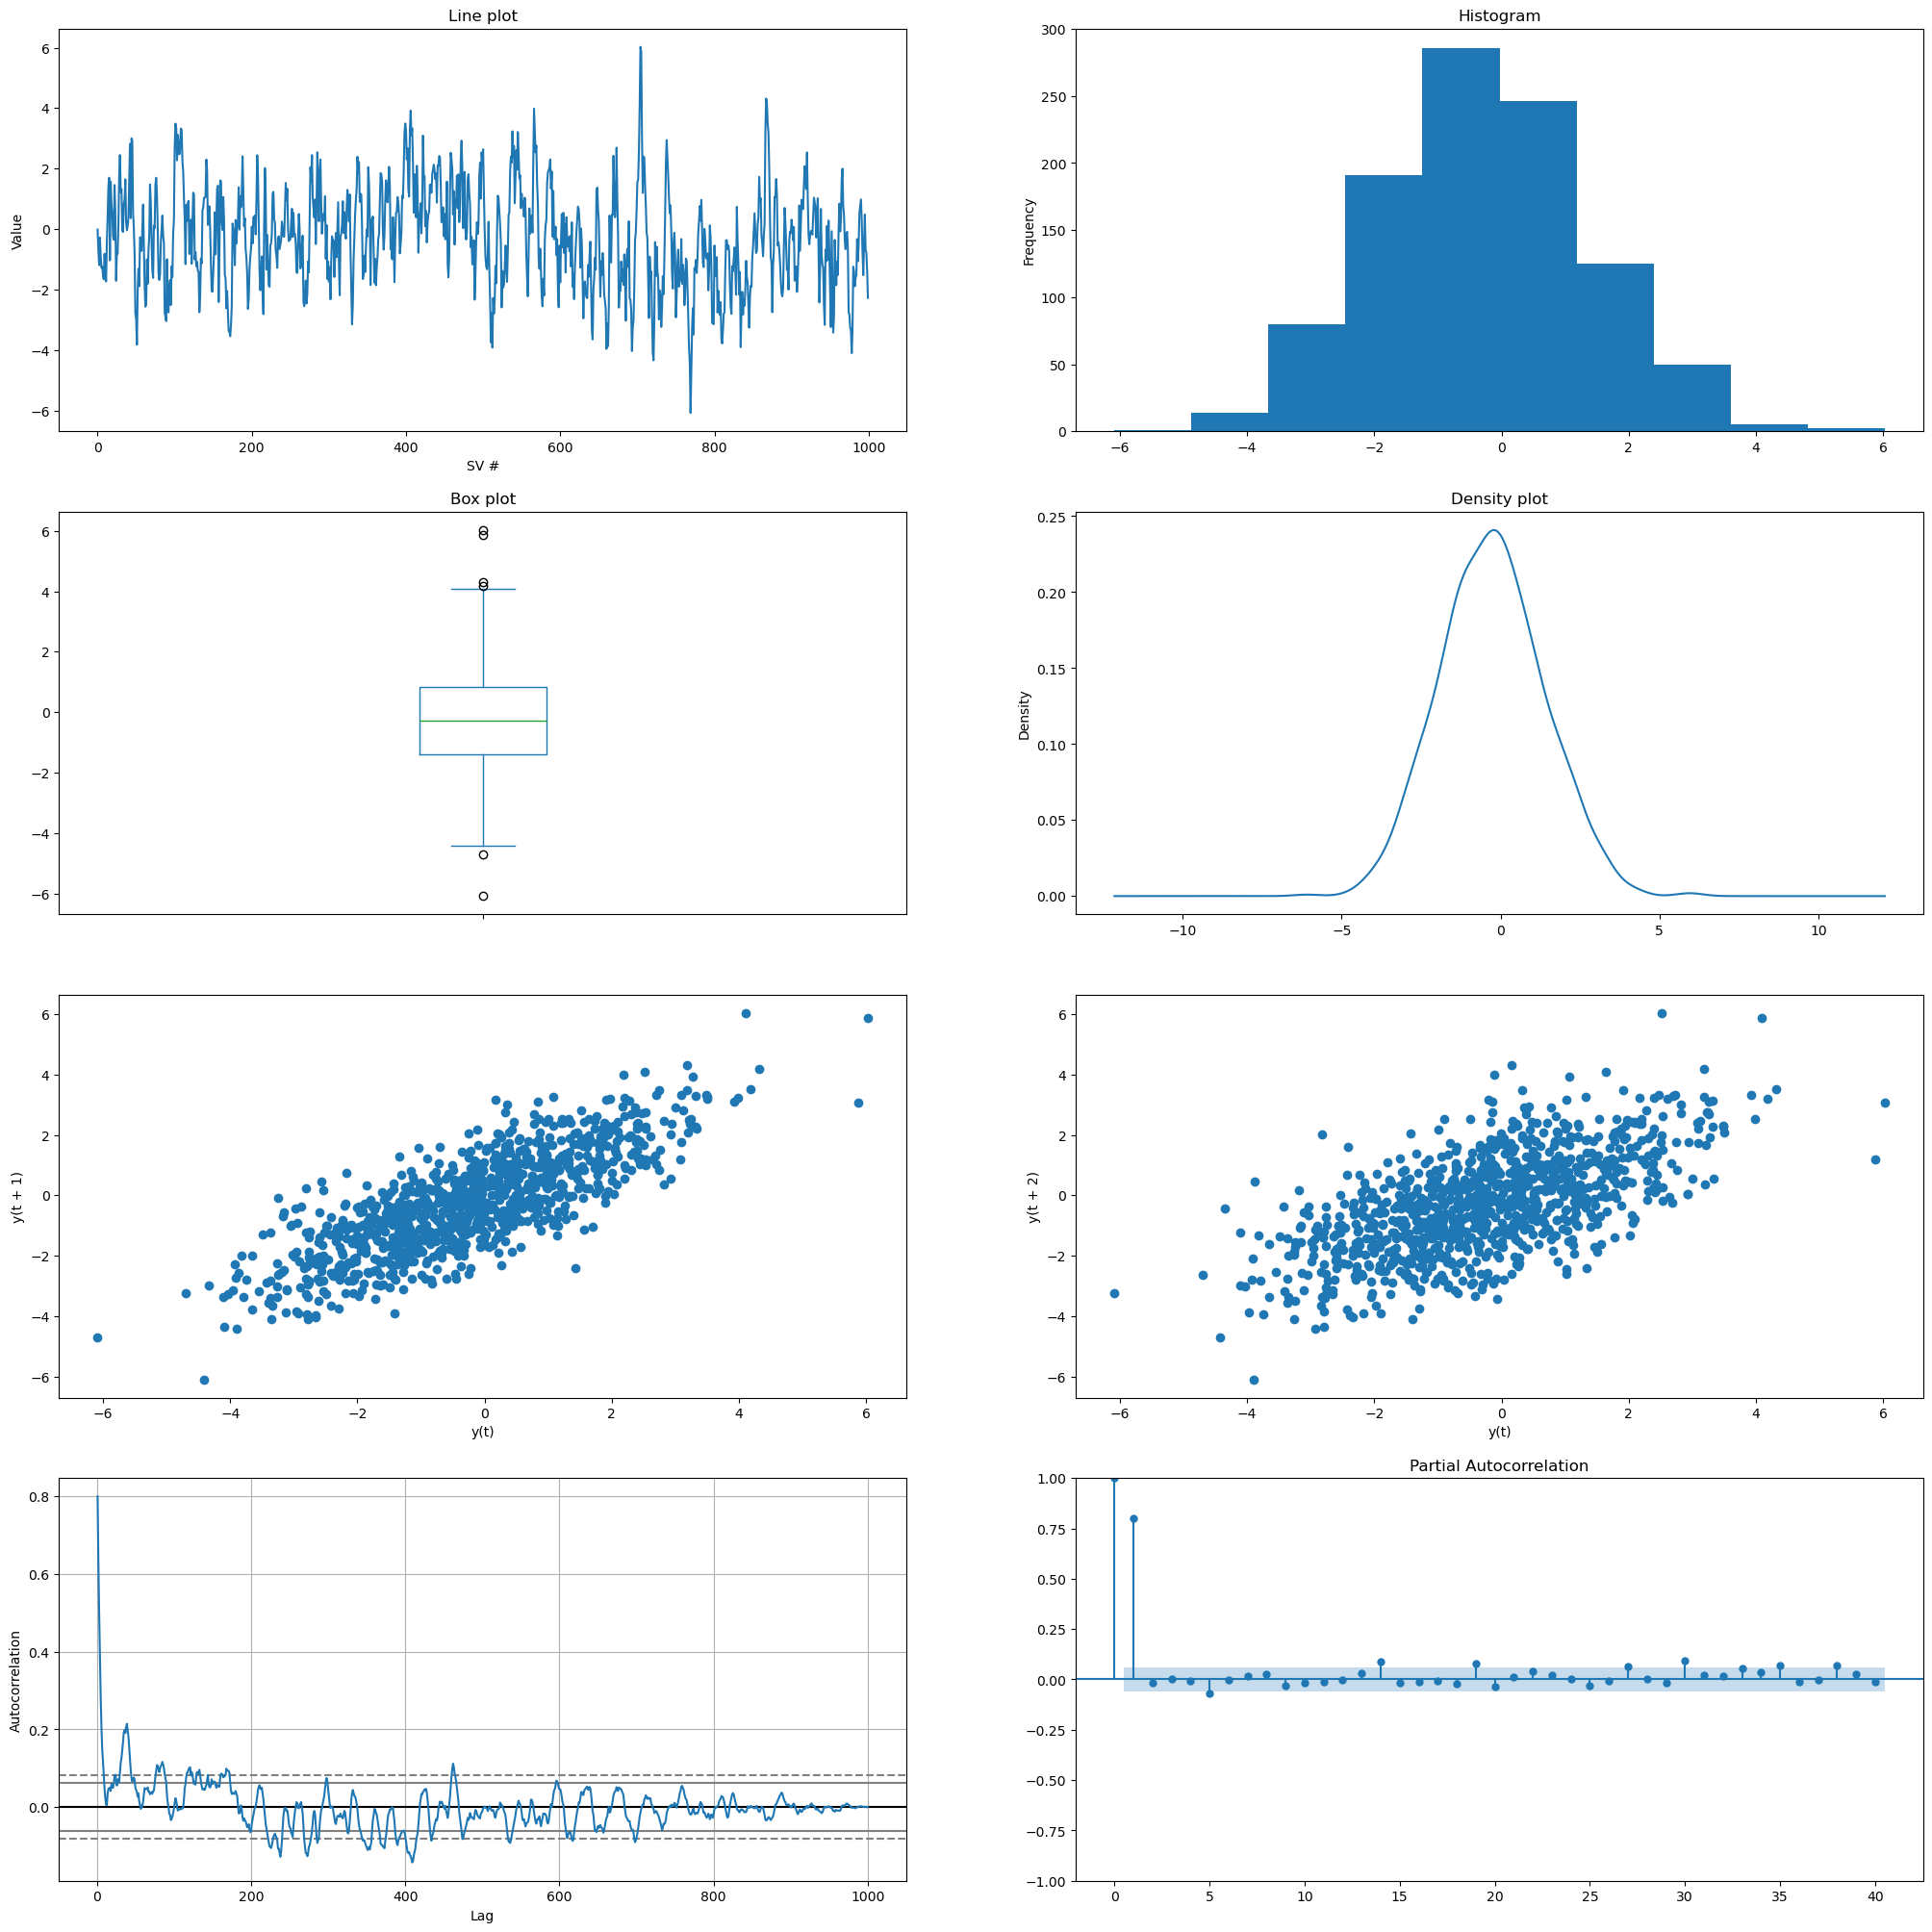

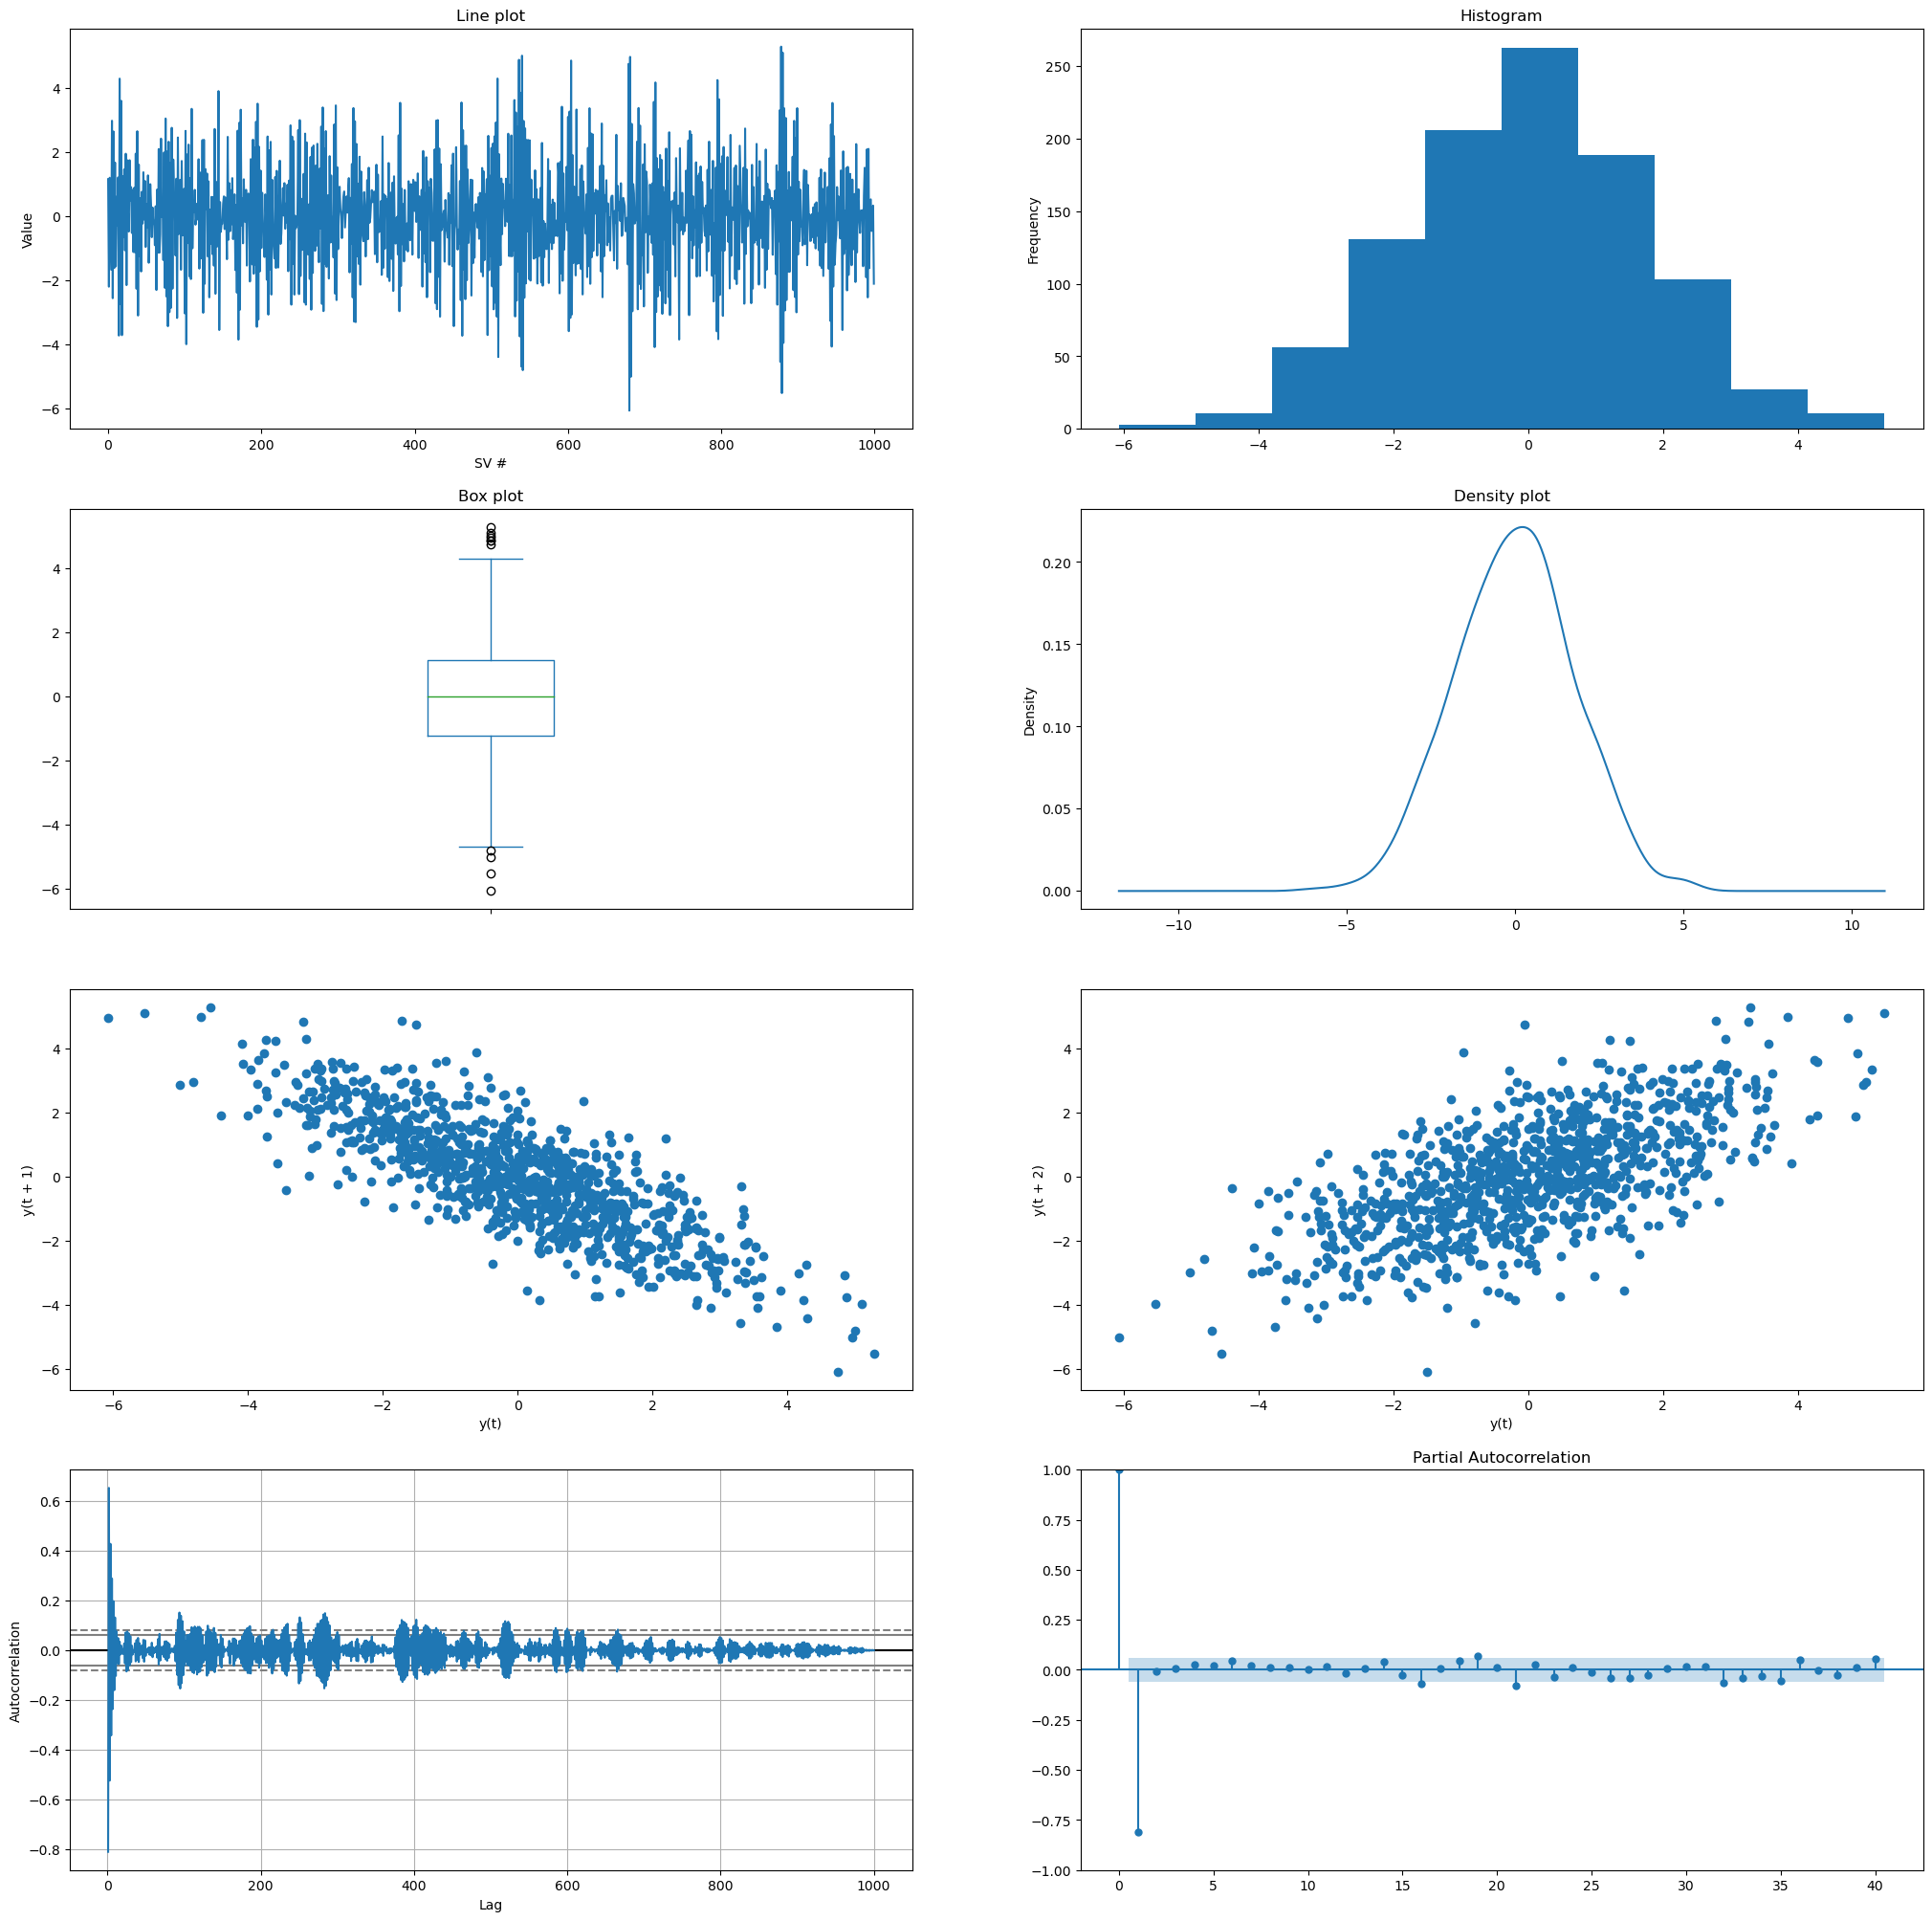

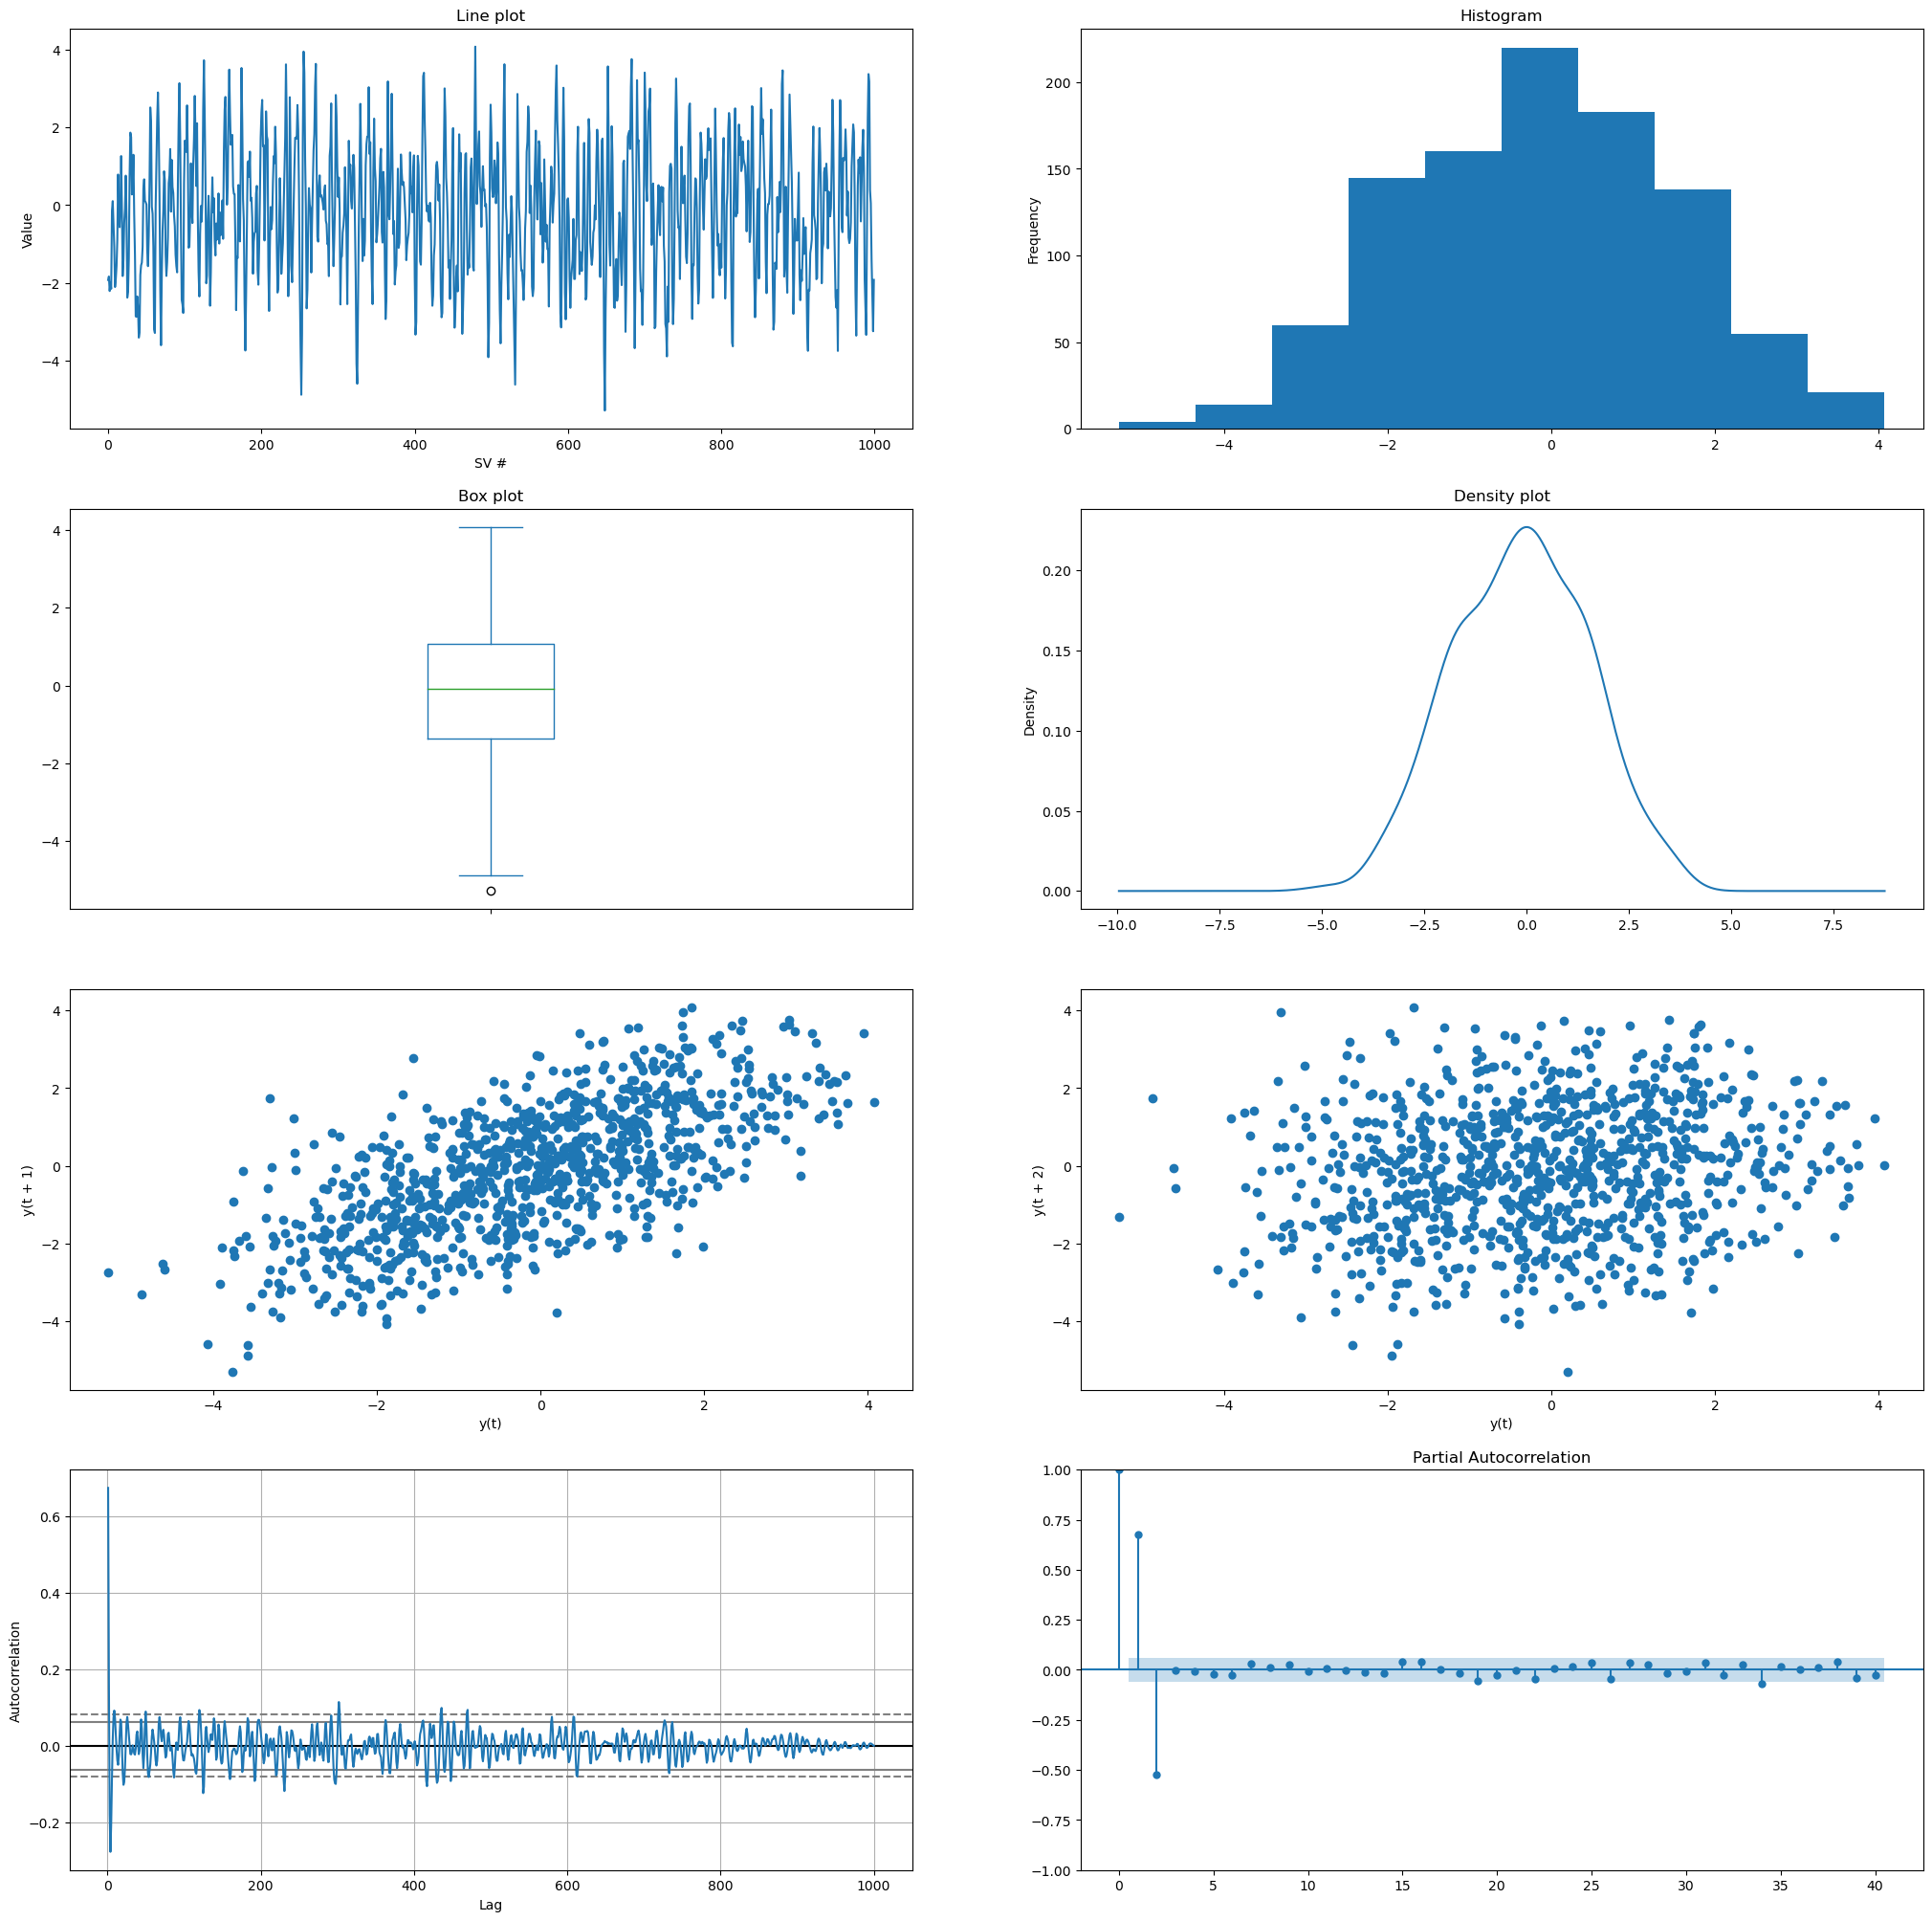

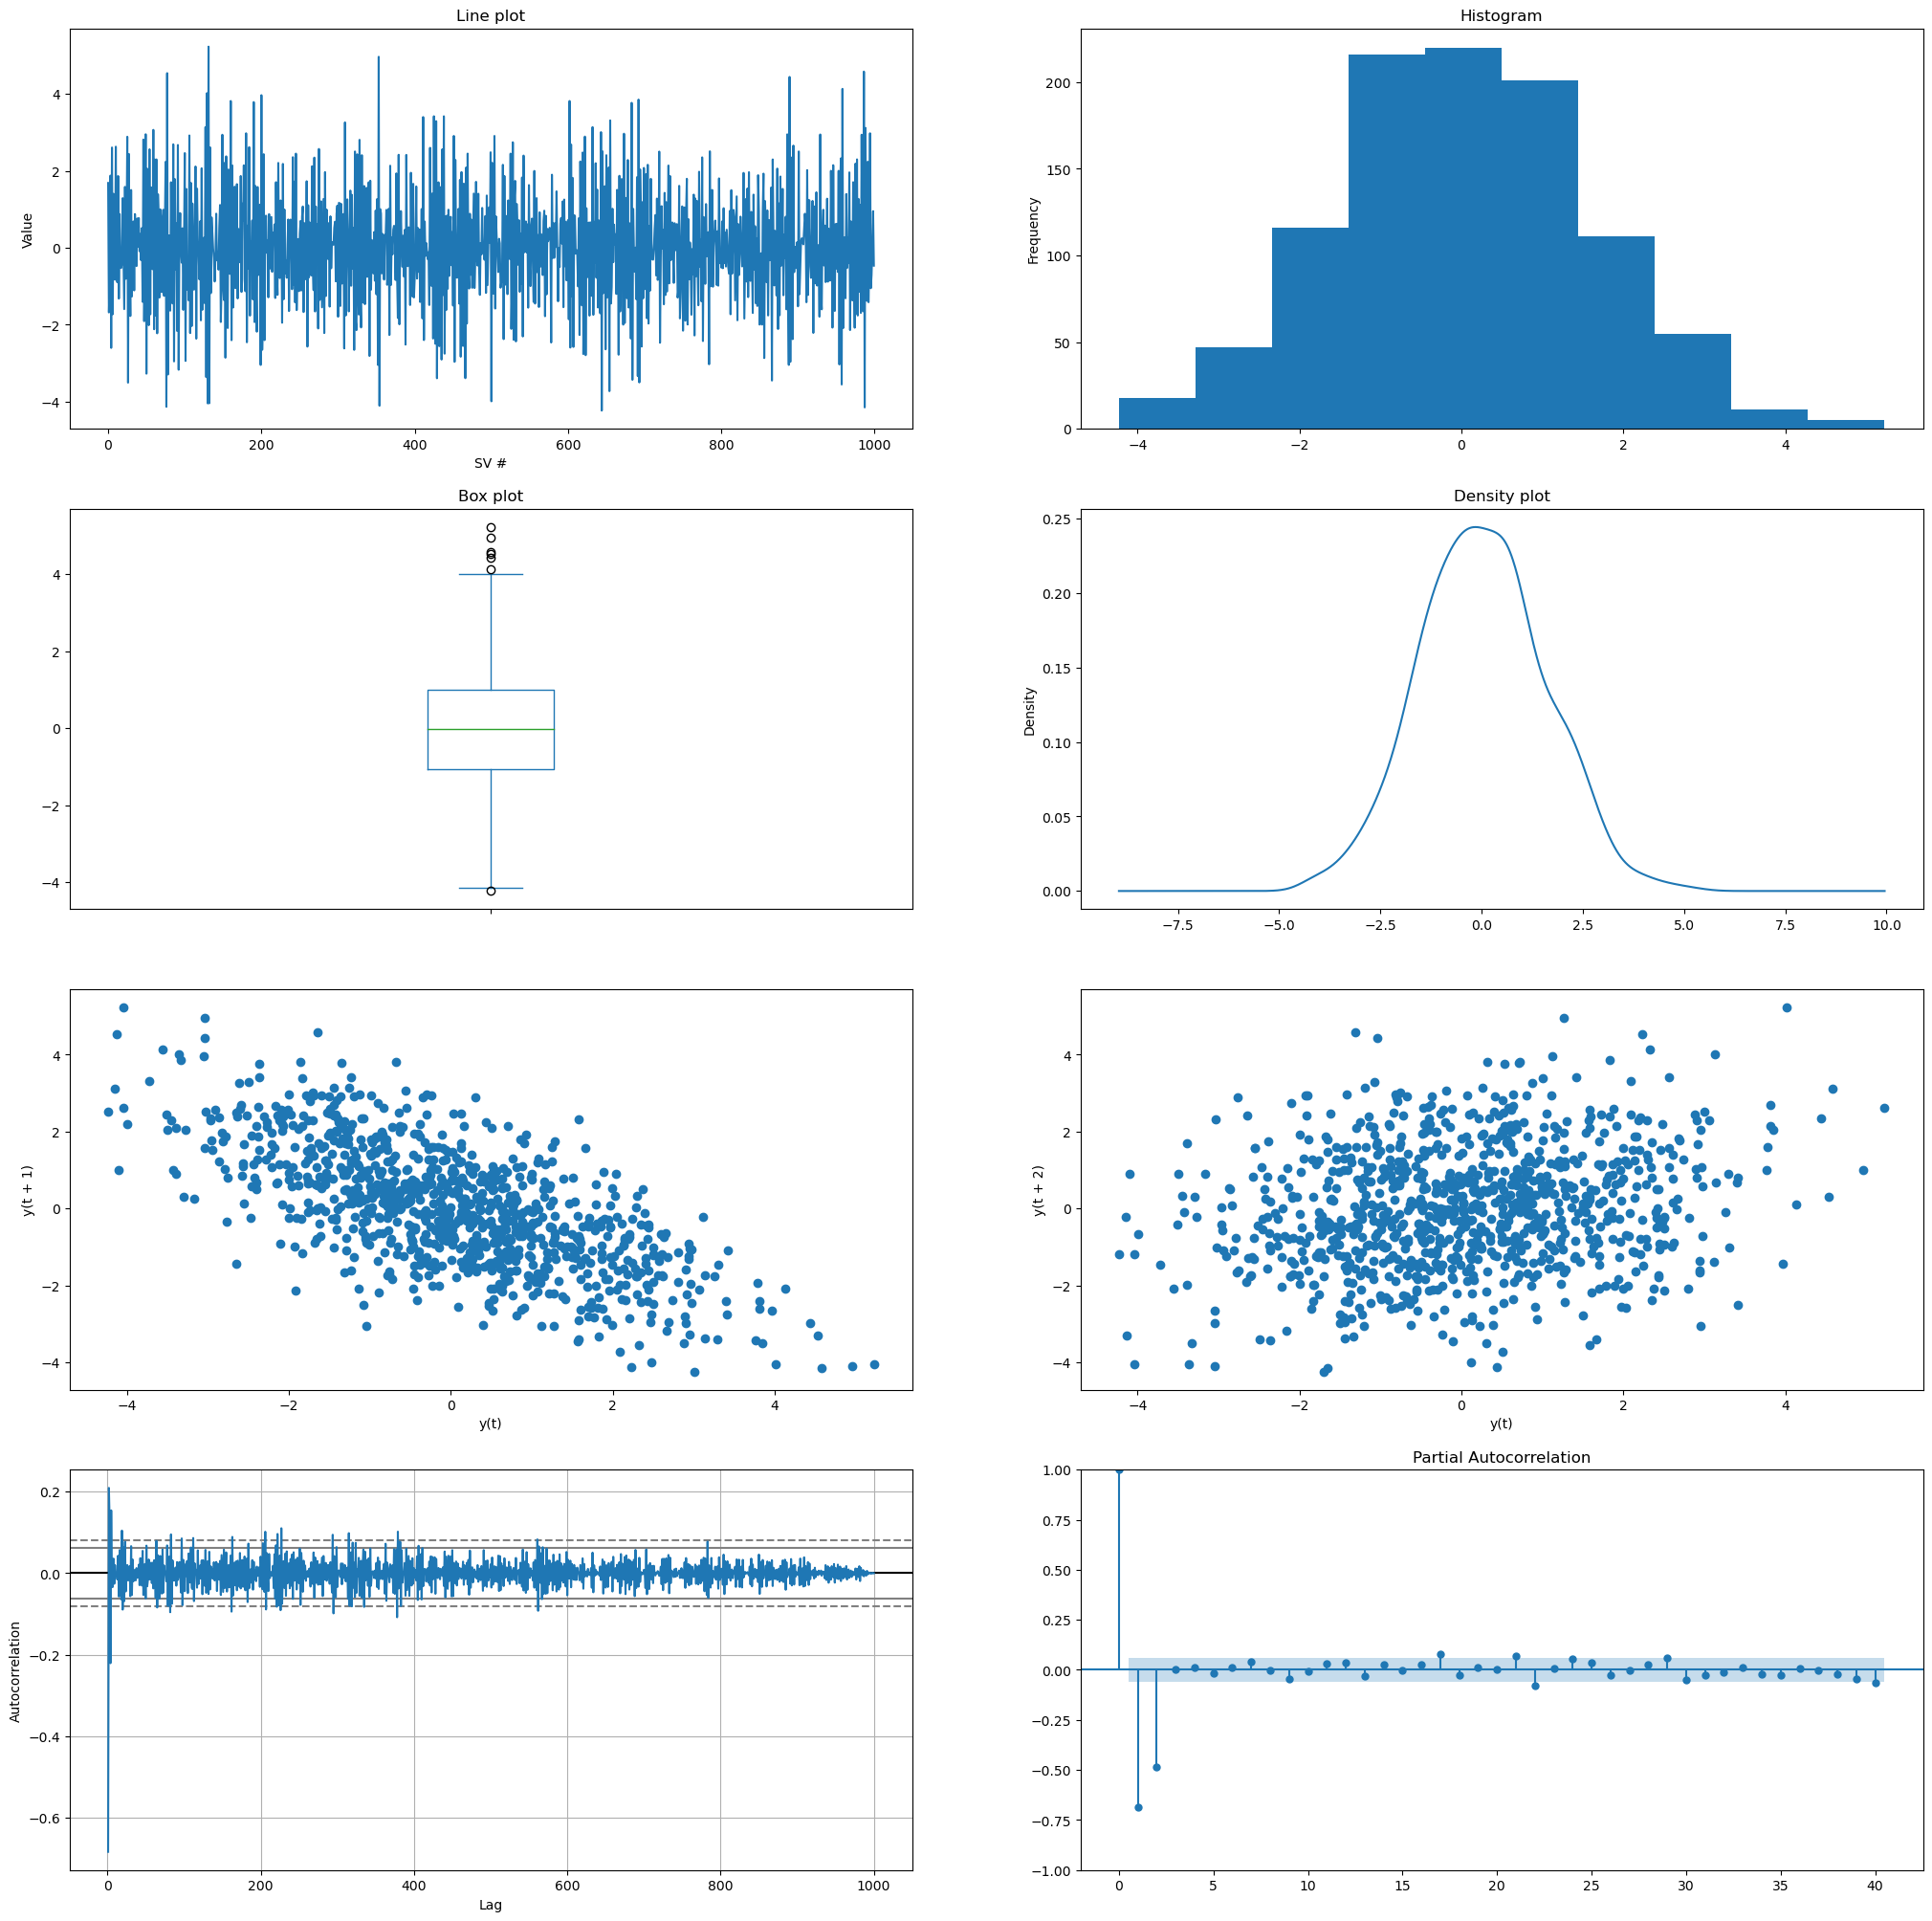

In [55]:
s1, p1 = gen_arma(lagcoeffs_ar=[0.8], nsample=1000)
s2, p2 = gen_arma(lagcoeffs_ar=[-0.8], nsample=1000)
s3, p3 = gen_arma(lagcoeffs_ar=[1, -0.5], nsample=1000)
s4, p4 = gen_arma(lagcoeffs_ar=[-1, -0.5], nsample=1000)

plot_all(Series(s1), lags=40);
plot_all(Series(s2), lags=40);
plot_all(Series(s3), lags=40);
plot_all(Series(s4), lags=40);